# **Dạy AI khiêu vũ**

**Machine Learning, Deep Learning, ANN và CNN hình ảnh đều đang thịnh hành ngày nay, ở đây mô hình sẽ  kết hợp các kỹ thuật từ CNN, cả kiến thức kế thừa từ những phương pháp trước để máy tính học cách tạo các video khiêu vũ của riêng nó. Dữ liệu được lấy từ video nhảy rồi đưa ảnh lên Drive**

In [ ]:
import os
import sys
import random
import warnings
from pylab import imshow, show, get_cmap

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, UpSampling2D, Flatten, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras import backend as K
import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PART_1_SKIP = True

In [ ]:
%%time
if PART_1_SKIP:
    IMG_WIDTH = 96
    IMG_HEIGHT = 64
    IMG_CHANNELS = 1
    INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    TRAIN_PATH = '/content/drive/MyDrive/Dancer_Images/data/'
    train_ids = next(os.walk(TRAIN_PATH))[2]
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype='float32')
    missing_count = 0
    print('Getting training images ... ')
#     sys.stdout.flush()
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH +'frame'+ str(n+1) + '.jpg'
        try:
            img = imread(path)
            img = img.astype('float32') / 255.
            img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
            X_train[n-missing_count] = img
        except:
            print(" Problem with: "+path)
            missing_count += 1

    print("Done! total missing: "+ str(missing_count))
else:
    INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Getting training images ... 


100%|██████████| 1000/1000 [00:24<00:00, 40.08it/s]

Done! total missing: 0
CPU times: user 4.19 s, sys: 5.43 s, total: 9.61 s
Wall time: 28.8 s


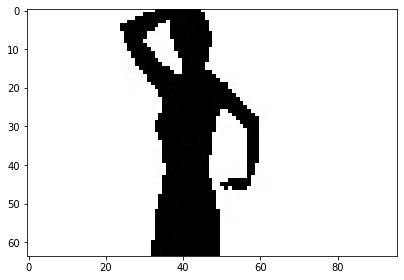

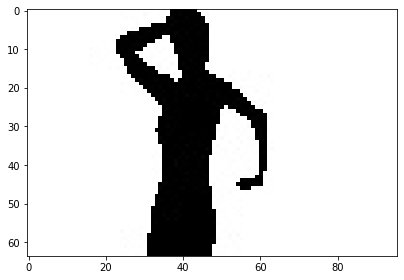

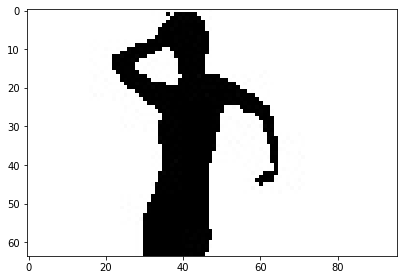

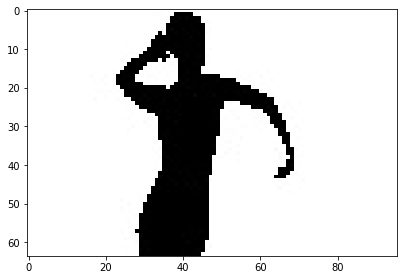

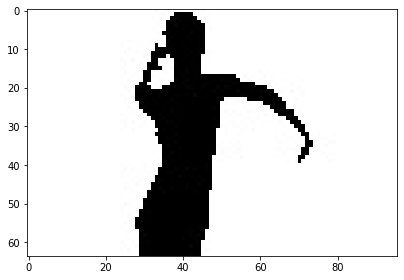

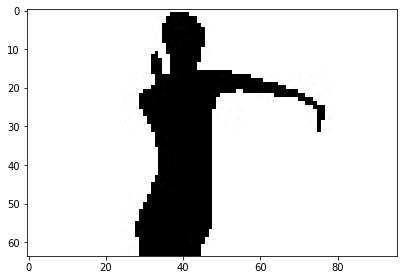

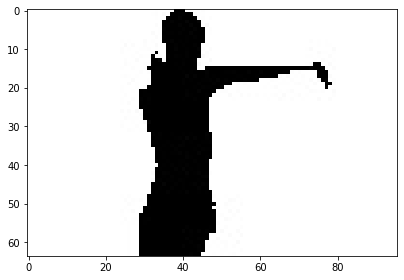

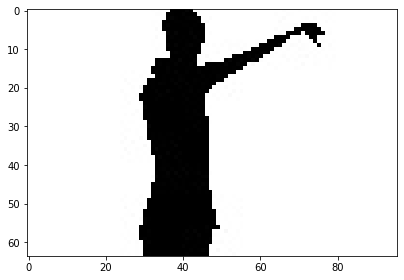

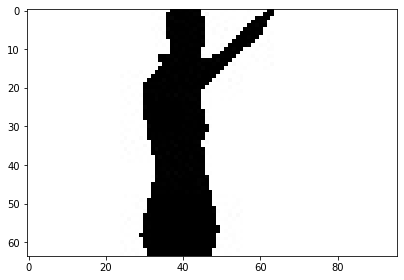

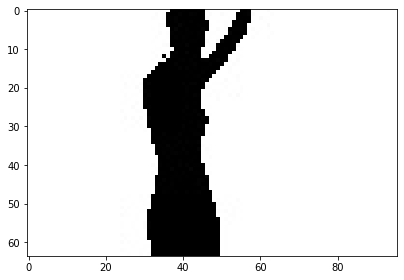

In [ ]:
for n in range(5,15):
    imshow(X_train[n].reshape(IMG_HEIGHT,IMG_WIDTH))
    plt.show()

# **Tạo MODEL**

In [ ]:
def Encoder():
    inp = Input(shape=INPUT_SHAPE)
    x = Conv2D(128, (4, 4), activation='elu', padding='same',name='encode1')(inp)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode2')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode3')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode4')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode5')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode6')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode7')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode8')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same',name='encode9')(x)
    x = Flatten()(x)
    x = Dense(256, activation='elu',name='encode10')(x)
    encoded = Dense(128, activation='sigmoid',name='encode11')(x)
    return Model(inp, encoded)

encoder = Encoder()
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 96, 1)]       0         
                                                                 
 encode1 (Conv2D)            (None, 64, 96, 128)       2176      
                                                                 
 encode2 (Conv2D)            (None, 64, 96, 64)        73792     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 48, 64)       0         
 )                                                               
                                                                 
 encode3 (Conv2D)            (None, 32, 48, 64)        36928     
                                                                 
 encode4 (Conv2D)            (None, 32, 48, 32)        8224      
                                                             

In [ ]:
D_INPUT_SHAPE=[128]
def Decoder():
    inp = Input(shape=D_INPUT_SHAPE, name='decoder')
    x = Dense(256, activation='elu', name='decode1')(inp)
    x = Dense(768, activation='elu', name='decode2')(x)
    x = Reshape((4, 6, 32))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode3')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode4')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode5')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode6')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode7')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode8')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode9')(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode10')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode11')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode12')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same', name='decode13')(x)
    x = Conv2D(16, (2, 2), activation='elu', padding='same', name='decode14')(x)
    decoded = Conv2D(1, (2, 2), activation='sigmoid', padding='same', name='decode15')(x)
    return Model(inp, decoded)

decoder = Decoder()
decoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder (InputLayer)        [(None, 128)]             0         
                                                                 
 decode1 (Dense)             (None, 256)               33024     
                                                                 
 decode2 (Dense)             (None, 768)               197376    
                                                                 
 reshape_3 (Reshape)         (None, 4, 6, 32)          0         
                                                                 
 decode3 (Conv2D)            (None, 4, 6, 32)          4128      
                                                                 
 decode4 (Conv2D)            (None, 4, 6, 64)          18496     
                                                                 
 up_sampling2d_12 (UpSamplin  (None, 8, 12, 64)        0   

In [ ]:
def Autoencoder():
    inp = Input(shape=INPUT_SHAPE)
    x = Conv2D(128, (4, 4), activation='elu', padding='same',name='encode1')(inp)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode2')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode3')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode4')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode5')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode6')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode7')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode8')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same',name='encode9')(x)
    x = Flatten()(x)
    x = Dense(256, activation='elu',name='encode10')(x)
    encoded = Dense(128, activation='sigmoid',name='encode11')(x)
    x = Dense(256, activation='elu', name='decode1')(encoded)
    x = Dense(768, activation='elu', name='decode2')(x)
    x = Reshape((4, 6, 32))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode3')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode4')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode5')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode6')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode7')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode8')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode9')(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode10')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode11')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode12')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same', name='decode13')(x)
    x = Conv2D(16, (2, 2), activation='elu', padding='same', name='decode14')(x)
    decoded = Conv2D(1, (2, 2), activation='sigmoid', padding='same', name='decode15')(x)
    return Model(inp, decoded)

model = Autoencoder()
model.compile(optimizer='adam', loss='mean_squared_error',metrics='accuracy')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 96, 1)]       0         
                                                                 
 encode1 (Conv2D)            (None, 64, 96, 128)       2176      
                                                                 
 encode2 (Conv2D)            (None, 64, 96, 64)        73792     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 48, 64)       0         
 2D)                                                             
                                                                 
 encode3 (Conv2D)            (None, 32, 48, 64)        36928     
                                                                 
 encode4 (Conv2D)            (None, 32, 48, 32)        8224      
                                                           

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)

checkpoint = ModelCheckpoint("Dancer_Auto_Model.hdf5",
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=8,
                              verbose=1,
                              mode='min',
                              restore_best_weights=True)

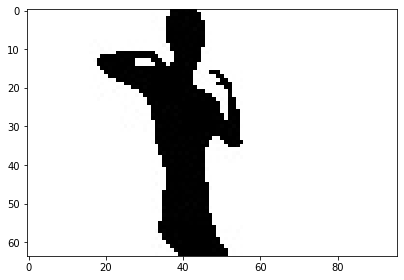

In [ ]:
class ImgSample(Callback):

    def __init__(self):
       super(Callback, self).__init__() 

    def on_epoch_end(self, epoch, logs={}):
        sample_img = X_train[50]
        sample_img = sample_img.reshape(1, IMG_HEIGHT, IMG_WIDTH, 1)
        sample_img = self.model.predict(sample_img)[0]
        imshow(sample_img.reshape(IMG_HEIGHT,IMG_WIDTH))
        plt.show()


imgsample = ImgSample()
model_callbacks = [learning_rate_reduction, checkpoint, early_stopping, imgsample]
imshow(X_train[20].reshape(IMG_HEIGHT,IMG_WIDTH))

# **Đào tạo**

Epoch 1/20
1/1 [==============================] - 0s 90ms/step


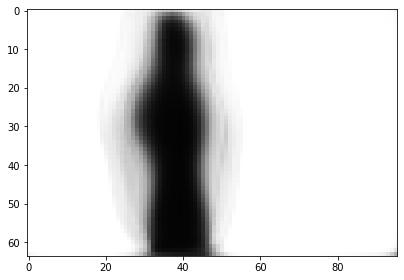

30/30 - 320s - loss: 0.0406 - accuracy: 0.8737 - val_loss: 0.0528 - val_accuracy: 0.8631 - lr: 0.0010 - 320s/epoch - 11s/step
Epoch 2/20
1/1 [==============================] - 0s 92ms/step


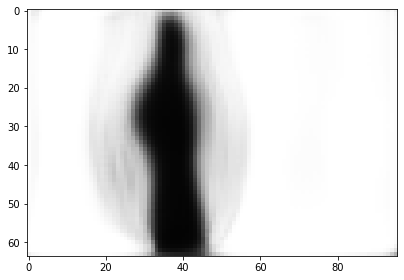

30/30 - 318s - loss: 0.0398 - accuracy: 0.8740 - val_loss: 0.0564 - val_accuracy: 0.8599 - lr: 0.0010 - 318s/epoch - 11s/step
Epoch 3/20
1/1 [==============================] - 0s 90ms/step


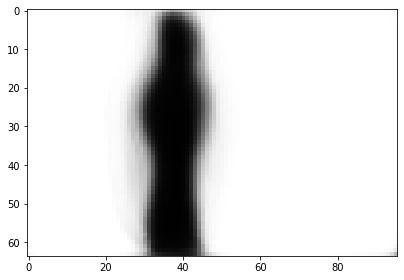

30/30 - 293s - loss: 0.0363 - accuracy: 0.8776 - val_loss: 0.0541 - val_accuracy: 0.8641 - lr: 0.0010 - 293s/epoch - 10s/step
Epoch 4/20
1/1 [==============================] - 0s 91ms/step


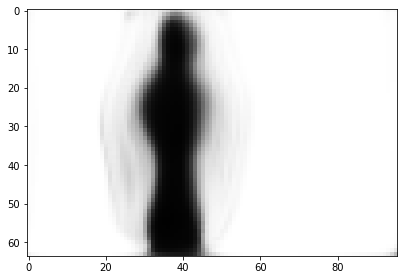

30/30 - 295s - loss: 0.0349 - accuracy: 0.8789 - val_loss: 0.0503 - val_accuracy: 0.8654 - lr: 0.0010 - 295s/epoch - 10s/step
Epoch 5/20
1/1 [==============================] - 0s 91ms/step


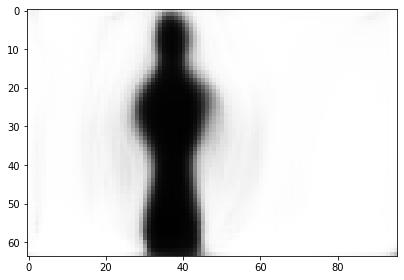

30/30 - 298s - loss: 0.0327 - accuracy: 0.8810 - val_loss: 0.0463 - val_accuracy: 0.8712 - lr: 0.0010 - 298s/epoch - 10s/step
Epoch 6/20
1/1 [==============================] - 0s 92ms/step


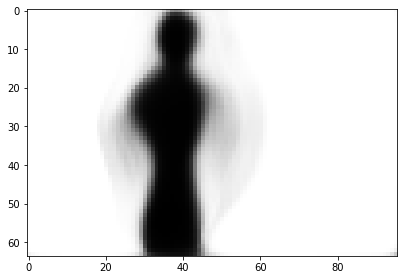

30/30 - 292s - loss: 0.0319 - accuracy: 0.8818 - val_loss: 0.0467 - val_accuracy: 0.8697 - lr: 0.0010 - 292s/epoch - 10s/step
Epoch 7/20
1/1 [==============================] - 0s 95ms/step


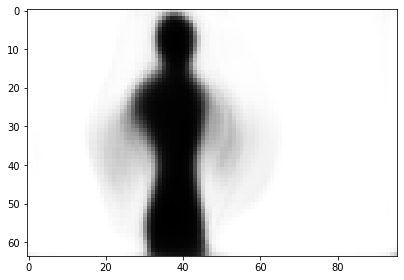

30/30 - 292s - loss: 0.0300 - accuracy: 0.8835 - val_loss: 0.0527 - val_accuracy: 0.8652 - lr: 0.0010 - 292s/epoch - 10s/step
Epoch 8/20
1/1 [==============================] - 0s 90ms/step


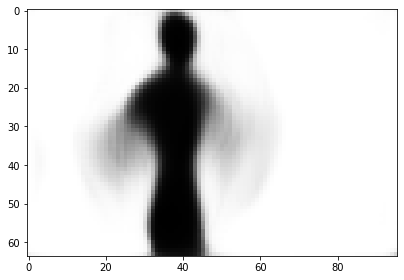

30/30 - 291s - loss: 0.0301 - accuracy: 0.8832 - val_loss: 0.0488 - val_accuracy: 0.8695 - lr: 0.0010 - 291s/epoch - 10s/step
Epoch 9/20
1/1 [==============================] - 0s 94ms/step


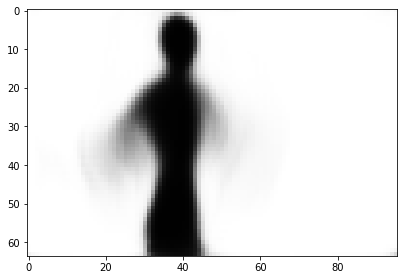

30/30 - 290s - loss: 0.0281 - accuracy: 0.8850 - val_loss: 0.0436 - val_accuracy: 0.8739 - lr: 0.0010 - 290s/epoch - 10s/step
Epoch 10/20
1/1 [==============================] - 0s 90ms/step


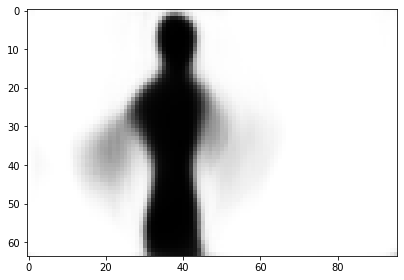

30/30 - 291s - loss: 0.0277 - accuracy: 0.8854 - val_loss: 0.0422 - val_accuracy: 0.8723 - lr: 0.0010 - 291s/epoch - 10s/step
Epoch 11/20
1/1 [==============================] - 0s 89ms/step


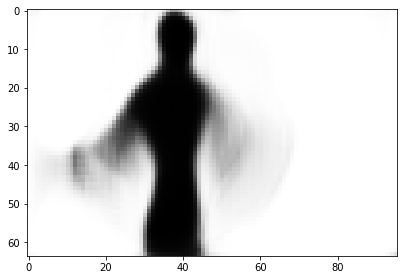

30/30 - 291s - loss: 0.0272 - accuracy: 0.8858 - val_loss: 0.0419 - val_accuracy: 0.8760 - lr: 0.0010 - 291s/epoch - 10s/step
Epoch 12/20
1/1 [==============================] - 0s 101ms/step


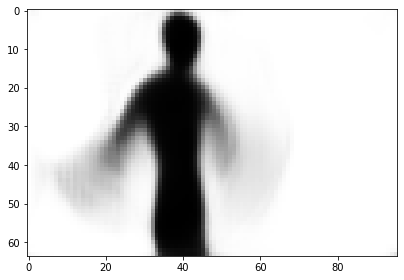

30/30 - 291s - loss: 0.0266 - accuracy: 0.8860 - val_loss: 0.0414 - val_accuracy: 0.8737 - lr: 0.0010 - 291s/epoch - 10s/step
Epoch 13/20
1/1 [==============================] - 0s 90ms/step


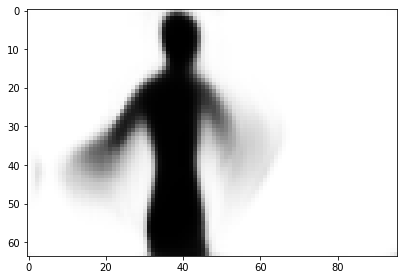

30/30 - 291s - loss: 0.0255 - accuracy: 0.8870 - val_loss: 0.0410 - val_accuracy: 0.8749 - lr: 0.0010 - 291s/epoch - 10s/step
Epoch 14/20
1/1 [==============================] - 0s 90ms/step


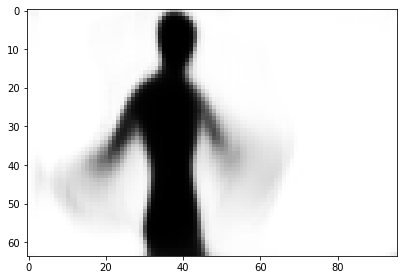

30/30 - 296s - loss: 0.0243 - accuracy: 0.8879 - val_loss: 0.0496 - val_accuracy: 0.8649 - lr: 0.0010 - 296s/epoch - 10s/step
Epoch 15/20
1/1 [==============================] - 0s 90ms/step


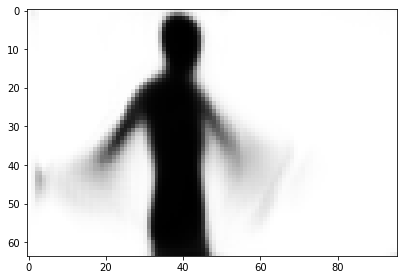

30/30 - 291s - loss: 0.0252 - accuracy: 0.8869 - val_loss: 0.0493 - val_accuracy: 0.8639 - lr: 0.0010 - 291s/epoch - 10s/step
Epoch 16/20
1/1 [==============================] - 0s 90ms/step


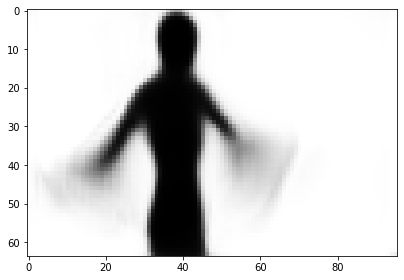

30/30 - 291s - loss: 0.0244 - accuracy: 0.8876 - val_loss: 0.0429 - val_accuracy: 0.8726 - lr: 0.0010 - 291s/epoch - 10s/step
Epoch 17/20

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 [==============================] - 0s 94ms/step


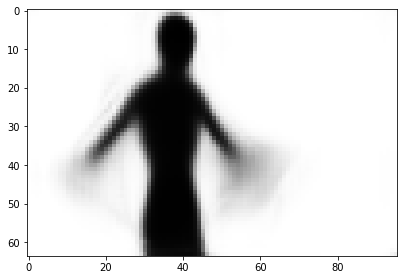

30/30 - 291s - loss: 0.0237 - accuracy: 0.8881 - val_loss: 0.0468 - val_accuracy: 0.8682 - lr: 0.0010 - 291s/epoch - 10s/step
Epoch 18/20
1/1 [==============================] - 0s 91ms/step


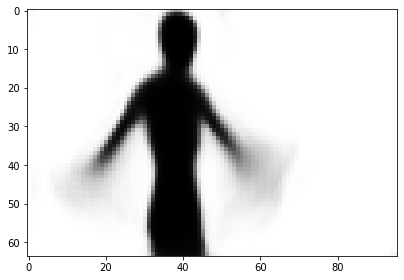

30/30 - 291s - loss: 0.0214 - accuracy: 0.8902 - val_loss: 0.0419 - val_accuracy: 0.8756 - lr: 5.0000e-04 - 291s/epoch - 10s/step
Epoch 19/20
1/1 [==============================] - 0s 92ms/step


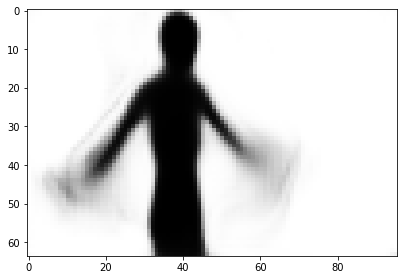

30/30 - 291s - loss: 0.0203 - accuracy: 0.8912 - val_loss: 0.0373 - val_accuracy: 0.8792 - lr: 5.0000e-04 - 291s/epoch - 10s/step
Epoch 20/20
1/1 [==============================] - 0s 93ms/step


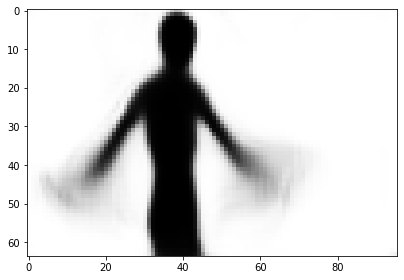

30/30 - 291s - loss: 0.0198 - accuracy: 0.8916 - val_loss: 0.0406 - val_accuracy: 0.8758 - lr: 5.0000e-04 - 291s/epoch - 10s/step


In [ ]:
history = model.fit(X_train, X_train,
              epochs=20, 
              batch_size=32,
              verbose=2,
              validation_split=0.05,
            callbacks=model_callbacks)

# **Độ sai số và Độ chính xác**


<ipython-input-36-016763752ad3>:5: MatplotlibDeprecationWarning: Unrecognized location ' lower right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(['Độ Sai số','Sai số'], loc=' lower right')


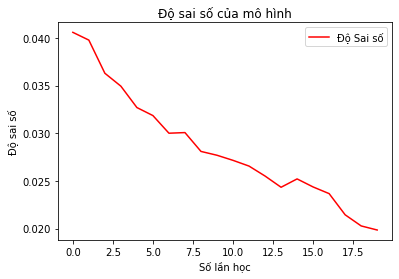

In [ ]:
plt.plot(history.history['loss'], color = 'red')
plt.title('Độ sai số của mô hình')
plt.ylabel('Độ sai số')
plt.xlabel('Số lần học')
plt.legend(['Độ Sai số','Sai số'], loc=' lower right')
plt.show()

<ipython-input-37-2bd73c852120>:5: MatplotlibDeprecationWarning: Unrecognized location ' lower right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(['Độ chính xác','Sai số'], loc=' lower right')


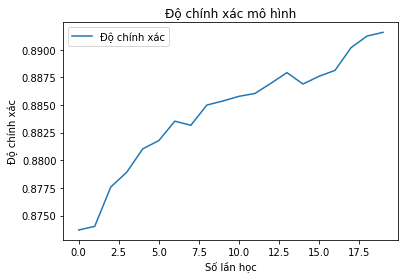

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Độ chính xác mô hình')
plt.ylabel('Độ chính xác')
plt.xlabel('Số lần học')
plt.legend(['Độ chính xác','Sai số'], loc=' lower right')
plt.show()

# **Dự Đoán**

In [ ]:
decoded_imgs = model.predict(X_train)

32/32 [==============================] - 69s 2s/step


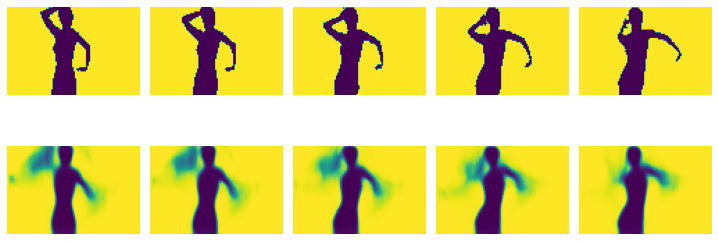

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(5,10):
    # original
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_train[i].reshape(IMG_HEIGHT, IMG_WIDTH))
    plt.axis('off')
 
    # reconstruction
    plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(decoded_imgs[i].reshape(IMG_HEIGHT, IMG_WIDTH))
    plt.axis('off')
 
plt.tight_layout()
plt.show()

In [ ]:
model.save('Dancer_Auto_Model.hdf5')
model.save_weights("Dancer_Auto_Weights.hdf5")

In [ ]:
encoder = Encoder()
decoder = Decoder()

encoder.load_weights("Dancer_Auto_Weights.hdf5", by_name=True)
decoder.load_weights("Dancer_Auto_Weights.hdf5", by_name=True)


decoder.save('Dancer_Decoder_Model.hdf5') 
encoder.save('Dancer_Encoder_Model.hdf5')

decoder.save_weights("Dancer_Decoder_Weights.hdf5")
encoder.save_weights("Dancer_Encoder_Weights.hdf5")

In [ ]:
encoder_imgs = encoder.predict(X_train)
print(encoder_imgs.shape)
np.save('Encoded_Dancer.npy',encoder_imgs)

32/32 [==============================] - 23s 710ms/step
(1000, 128)


1/1 [==============================] - 1s 659ms/step


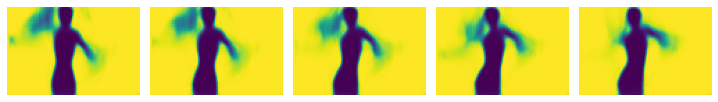

In [ ]:
decoded_imgs = decoder.predict(encoder_imgs[0:11])

plt.figure(figsize=(20, 4))
for i in range(5,10):
    # reconstruction
    plt.subplot(1, 10, i + 1)
    plt.imshow(decoded_imgs[i].reshape(IMG_HEIGHT, IMG_WIDTH))
    plt.axis('off')
 
plt.tight_layout()
plt.show()

# **Output the Dance**

In [ ]:
Decoder = load_model('Dancer_Decoder_Model.hdf5')
Decoder.load_weights('Dancer_Decoder_Weights.hdf5')

Dance_Output = Decoder.predict(encoder_imgs)
Dance_Output.shape

32/32 [==============================] - 45s 1s/step


(1000, 64, 96, 1)

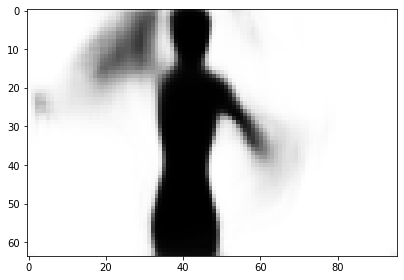

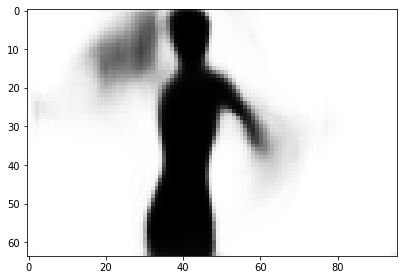

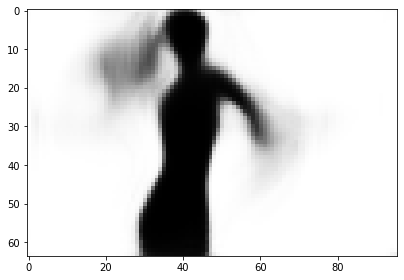

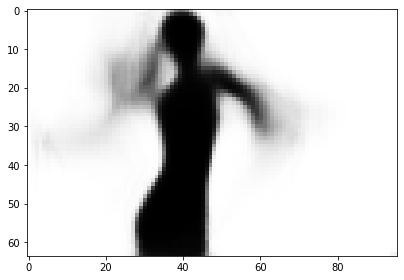

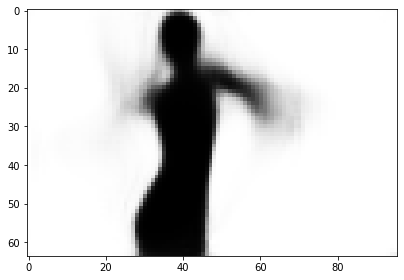

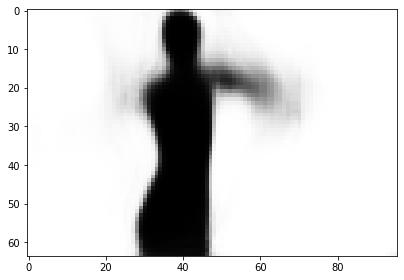

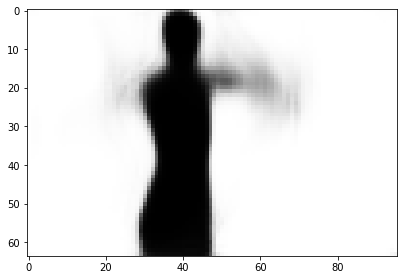

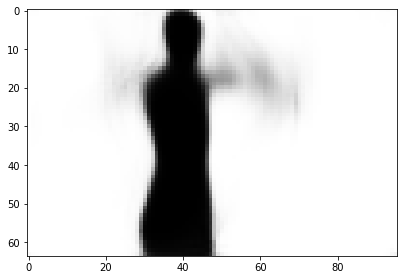

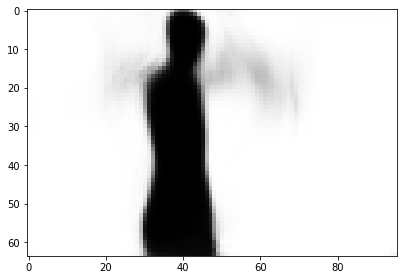

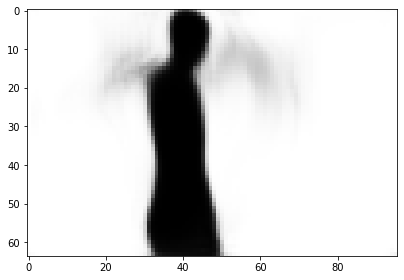

In [ ]:
IMG_HEIGHT = Dance_Output[0].shape[0]
IMG_WIDTH = Dance_Output[0].shape[1]

for row in Dance_Output[5:15]:
    imshow(row.reshape(IMG_HEIGHT,IMG_WIDTH))
    plt.show()

In [ ]:
import cv2

In [ ]:
video = cv2.VideoWriter('AI_Dance_Video.avi', cv2.VideoWriter_fourcc(*"XVID"), 20.0, (IMG_WIDTH, IMG_HEIGHT),False)

for img in Dance_Output:
    img = resize(img, (IMG_HEIGHT,IMG_WIDTH), mode='constant', preserve_range=True)
    img = img * 255
    img = img.astype('uint8')
    video.write(img)
    cv2.waitKey(50)
    
video.release()

# **Kết quả**

**Kết quả của video cũng mượt mà một cách đáng ngạc nhiên.Với khoảng chừng 2 tiếng đồng hồ để đào tạo với độ chính xác hơn 89 % thì kết quả rất thỏa mãn. Ngay cả những điều nhỏ nhặt như uốn người cũng được ghi lại trong video. Giống như trong video trích xuất ảnh để đào tạo, những kết quả này khá giống và máy học chủ yếu sao chép các điệu nhảy. Tuy nhiên, có một số biến thể và biến dạng thú vị trong video. Người vũ công đôi khi sẽ thu nhỏ và mở rộng cánh tay của mình hoặc nén lại tạo ra một số kết quả thú vị.**